In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as st
# import scipy.linalg as linalg
# import scipy.optimize as so
# import statsmodels.api as sm
# import statsmodels.graphics.tsaplots as sm 
import random
# import time
import math
from sklearn.linear_model import LinearRegression


# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from numpy import matlib
# from scipy import io
# from scipy.special import erf
# from scipy.fftpack import fft, ifft
# from scipy import interpolate as intrp
# from matplotlib import rc
# from tools import *

np.random.seed(42)

# Point 1 - Basic ABC rejection algorithm

In [2]:
def discrepancy_metric(x, sample_mean=0):
    # rho(S(D*),S(D)) = abs(mean(x*) - mean(x)), we assume that mean(x)=0 (sample mean)
    return abs(np.mean(x) - sample_mean)

def true_mixture_distribution(x, M, a, var, var_1, sample_mean=0):
    alfa = 1./( 1 + np.exp( a * (sample_mean - 0.5*a) * M / (M*var + var_1) ) )
    pdf_1 = alfa * st.norm.pdf(x=x, loc = var/(var+var_1/M)*sample_mean, scale = np.sqrt(var_1/(M+var_1/var)))
    pdf_2 = (1-alfa) * st.norm.pdf(x=x, loc = var/(var+var_1/M)*(sample_mean-a), scale = np.sqrt(var_1/(M+var_1/var)))
    # f = alfa * st.norm(loc = var/(var+var_1/M)*sample_mean, scale = var_1/(M+var_1/var)) + (1-alfa) * st.norm(loc = var/(var+var_1/M)*(sample_mean-a), scale = var_1/(M+var_1/var))
    f = pdf_1 + pdf_2
    return f

def generate_data(M, theta, var, var_1, a):
    D = np.zeros(M)
    # do stuff ...
    return D

def basic_abc(N, M, eps, var, var_1, a):
    theta = np.zeros(N) #at the end of the algorithm it has to be full (algorithm ends when we have selected N samples)
    pi_rv = st.norm(loc=0, scale=np.sqrt(var))
    rejection_count = 0
    n1_count = 0  #DEBUG
    n2_count = 0  #DEBUG
    i = 0 # count of the number of selected samples
    
    while i < N:
        # sample candidate parameters from the prior distribution pi = N(0,var)
        theta_star = pi_rv.rvs()
    
        # generate data from the underlying model given theta_star
        # D observed data, is an iid sample drawn with prob=0.5 from N(theta,var_1), o/w from N(theta+a,var_1)
        N1_rv = st.norm(loc=theta_star, scale=np.sqrt(var_1))
        N2_rv = st.norm(loc=theta_star + a, scale=np.sqrt(var_1))
        D = np.zeros(M)
        
        #build a set of M observation from the underlying model given theta_star
        for j in range(M):
            if np.random.choice([0, 1]) == 0:
                D[j] = N1_rv.rvs()
                n1_count += 1
            else:
                D[j] = N2_rv.rvs()
                n2_count += 1
        
        if discrepancy_metric(D) < eps:
            theta[i] = theta_star
            i += 1 # a new sample is selected
        else:
            rejection_count += 1
    
    print('acceptance rate:', N/(N + rejection_count))
    return theta

In [3]:
# set problem parameters
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [0.75, 0.25, 0.1, 0.025]  # tolerances
N = 500  # max number of accepted samples

In [4]:
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)

theta_list = []

for e in eps:
    theta = basic_abc(N, M, e, var, var_1, a)
    theta_list.append(theta)

77455 77245
acceptance rate: 0.32320620555914675
242119 241581
acceptance rate: 0.10336985734959686
569826 569374
acceptance rate: 0.04389044943820225
2305405 2307495
acceptance rate: 0.010839168418998894


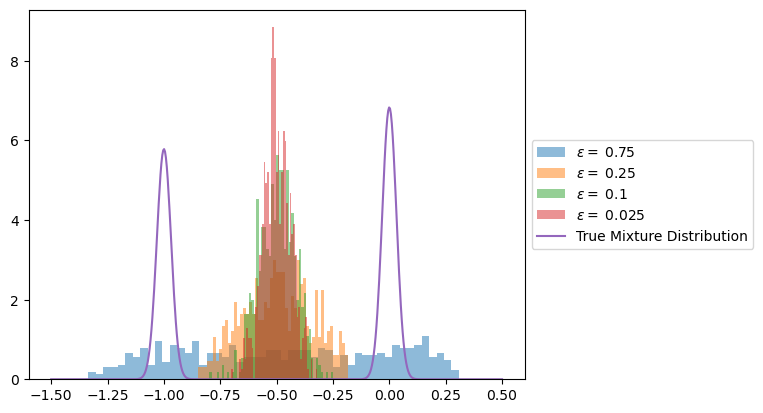

In [33]:
plt.figure()

for i in (range(len(eps))):
    plt.hist(theta_list[i], density=True, bins=50, alpha=0.5, label=r'$\epsilon =$ %s' % eps[i])
    
plt.plot(x_values, f, label='True Mixture Distribution')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

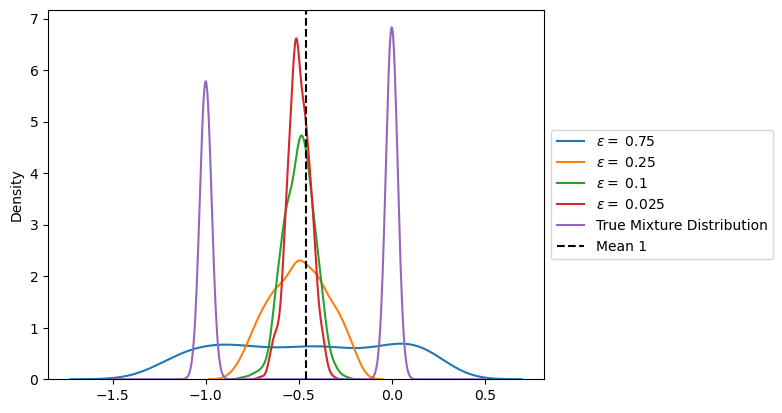

In [39]:
plt.figure()

for i in (range(len(eps))):
    sns.kdeplot(theta_list[i], label=r'$\epsilon =$ %s' % eps[i])
    
plt.plot(x_values, f, label='True Mixture Distribution')
plt.axvline(x=0+(1-alpha)*var/(var+var_1/M)*(sample_mean-a), color='black', linestyle='--', label='Mean 1')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [41]:
sample_mean = 0
alpha =  1./( 1 + np.exp( a * (sample_mean - 0.5*a) * M / (M*var + var_1) ) )

print("mu1 is:", var/(var+var_1/M)*sample_mean, ", sdt1 is:", np.sqrt(var_1/(M+var_1/var)))
print("mu2 is:", var/(var+var_1/M)*(sample_mean-a), ", std2 is:", np.sqrt(var_1/(M+var_1/var)))
print("alpha is:",alpha)

print("mean of true mixture distribution is:",(1-alpha)*var/(var+var_1/M)*(sample_mean-a))

mu1 is: 0.0 , sdt1 is: 0.03161750745616664
mu2 is: -0.9996667777407531 , std2 is: 0.03161750745616664
alpha is: 0.5415566948980146
mean of true mixture distribution is: -0.4582905415881227


# Point 3 - ABC-MCMC algorithm

## ver. 1.0

In [16]:
# set problem parameters
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [0.75, 0.25, 0.1, 0.025]  # tolerances

def abc_mcmc(N_max, N_eff, M, eps, nu_squared, var, var_1, a):
    theta = np.zeros(N_max+1)
    pi_rv = st.norm(loc=0, scale=nu_squared)  # prior ?
    acceptance_count = 0
    rejection_count = 0
    entered = 0
    i = 0
    while (acceptance_count < N_eff) & (i < N_max):
        # sample candidate parameters from a proposal transition density q(theta_i, )
        # random walk proposal q(theta, ) = N(theta,nu_squared)
        q_i = st.norm(loc=theta[i], scale=nu_squared)
        theta_star = q_i.rvs()
    
        # generate data from the underlying model given theta_star
        # generate_data function: TODO
        N1_rv = st.norm(loc=theta_star, scale=var_1)
        N2_rv = st.norm(loc=theta_star + a, scale=var_1)
        D = np.zeros(M)
        for j in range(M):
            if st.uniform.rvs(0,1) < 0.5:
                D[j] = N1_rv.rvs()
                # n1_count = n1_count + 1
            else:
                D[j] = N2_rv.rvs()
                # n2_count = n1_count + 1
    
        if discrepancy_metric(D) < eps:
            q_star = st.norm(loc=theta_star, scale=nu_squared)
            comp = pi_rv.pdf(theta_star)*q_star.pdf(theta[i])/( pi_rv.pdf(theta[i])*q_i.pdf(theta_star) )

            entered = entered + 1
            if st.uniform.rvs() < comp:
                theta[i+1] = theta_star
                acceptance_count = acceptance_count + 1 
            else:
                theta[i+1] = theta[i]
                rejection_count = rejection_count + 1
        else:
            theta[i+1] = theta[i]
            rejection_count = rejection_count + 1
        i = i + 1
    
    print(acceptance_count, entered, rejection_count, i) ## DEBUG
    if acceptance_count == 500:
        print('effective sample size achieved')
    print('acceptance rate:', acceptance_count/(acceptance_count+rejection_count))
    return theta

500 697 225 725
effective sample size achieved
acceptance rate: 0.6896551724137931
500 1429 3730 4230
effective sample size achieved
acceptance rate: 0.1182033096926714
0 0 5000 5000
acceptance rate: 0.0
0 1 5000 5000
acceptance rate: 0.0


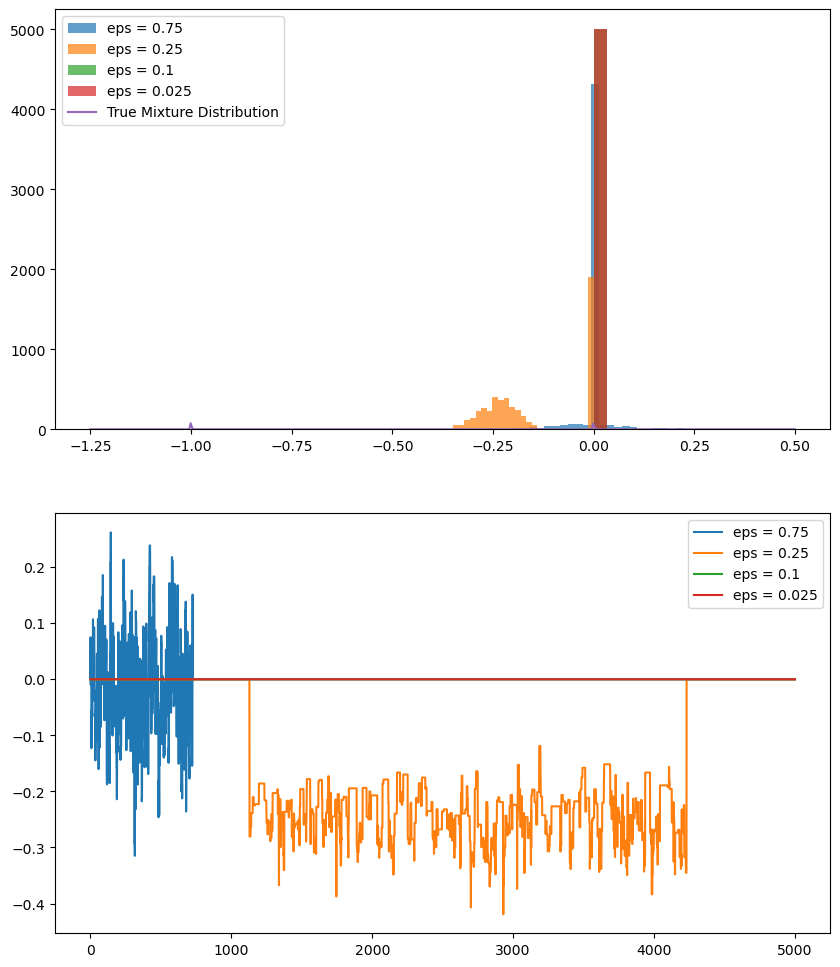

In [17]:
N_max = 5000  # max number of accepted samples ### TEMP
N_eff = 500  # effective size
nu_squared = var_1  ### TEMP

x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)

fig, axs = plt.subplots(2, figsize=(10,12))
for e in eps:
    theta = abc_mcmc(N_max, N_eff, M, e, nu_squared, var, var_1, a)
    label = 'eps = %s'%(e)
    axs[0].hist(theta, bins=30, alpha=0.7, label=label)
    axs[1].plot(theta, label=label)
axs[0].plot(x_values, f, label='True Mixture Distribution')
axs[0].legend()
axs[1].legend()
plt.show()

## ver. 1.1 - effective sample size

522 1525 4478 5000
acceptance rate: 0.1044


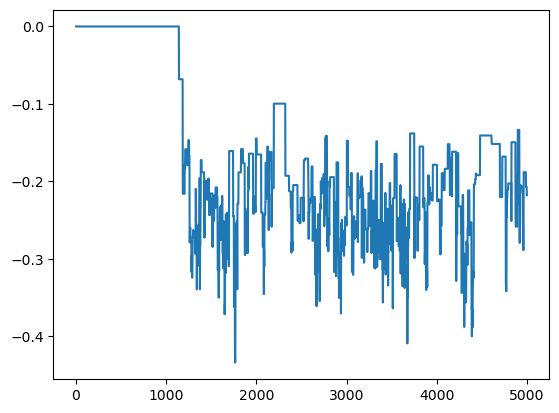

In [61]:
### Update effective sample size: ESS = N c(0)/sigma^2
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [0.75, 0.25, 0.1, 0.025]  # tolerances

# N_max = 5000  # max number of accepted samples
N_eff = 500  # effective size
nu_squared = var_1  # TEMP

def abc_mcmc(N_max, M, eps, nu_squared, var, var_1, a):
    theta = np.zeros(N_max+1)
    pi_rv = st.norm(loc=0, scale=nu_squared)  # prior ?
    acceptance_count = 0
    rejection_count = 0
    entered = 0
    i = 0
    while i < N_max:
        # sample candidate parameters from a proposal transition density q(theta_i, )
        # random walk proposal q(theta, ) = N(theta,nu_squared)
        q_i = st.norm(loc=theta[i], scale=nu_squared)
        theta_star = q_i.rvs()
    
        # generate data from the underlying model given theta_star
        # generate_data function: TODO
        N1_rv = st.norm(loc=theta_star, scale=np.sqrt(var_1))
        N2_rv = st.norm(loc=theta_star + a, scale=np.sqrt(var_1))
        D = np.zeros(M)
        for j in range(M):
            if st.uniform.rvs(0,1) < 0.5:
                D[j] = N1_rv.rvs()
                # n1_count = n1_count + 1
            else:
                D[j] = N2_rv.rvs()
                # n2_count = n1_count + 1
    
        if discrepancy_metric(D) < eps:
            q_star = st.norm(loc=theta_star, scale=nu_squared)
            comp = pi_rv.pdf(theta_star)*q_star.pdf(theta[i])/( pi_rv.pdf(theta[i])*q_i.pdf(theta_star) )
            
            entered = entered + 1
            if st.uniform.rvs() < comp:
                theta[i+1] = theta_star
                acceptance_count = acceptance_count + 1 
            else:
                theta[i+1] = theta[i]
                rejection_count = rejection_count + 1
        else:
            theta[i+1] = theta[i]
            rejection_count = rejection_count + 1
        i = i + 1
    
    print(acceptance_count, entered, rejection_count, i) ## DEBUG
    #if acceptance_count == 500:
    #    print('effective sample size achieved')
    print('acceptance rate:', acceptance_count/(acceptance_count+rejection_count))
    return theta

# estimate the asymptotic variance (covariance method)
N_max = 5000  # 10*N_eff
e = 0.25
c_hat = []
theta = abc_mcmc(N_max, M, e, nu_squared, var, var_1, a)
plt.plot(theta, label='eps=%s'%(e))

In [62]:
### update (cont.)
b = 1000  # burn-in
mu_hat = theta[b:].mean()
k = 0
while k < N_max-1:
    c_hat.append(1/(N_max-k-1)*np.multiply(theta[b:N_max-k+1] - mu_hat, theta[b+k:] - mu_hat).sum())
    k = k + 1

In [63]:
### update (cont.)
for k, _ in enumerate(c_hat):
    if c_hat[2*k] - c_hat[2*k+1] < 0:
        M_eff = 2*k
        break
print(M_eff)

106


In [64]:
var_M_hat = c_hat[0] + 2*sum(c_hat[1:M_eff+1])
var_hat = c_hat[0] + 2*sum(c_hat[1:])

print('sigma^2^hat =', var_hat)
print('sigma^2^hat_M =', var_M_hat)

sigma^2^hat = -0.08746732401299283
sigma^2^hat_M = 0.39467468209740497


In [65]:
N_max = math.ceil(N_eff*var_M_hat/c_hat[0])
print('N_max =', N_max)

N_max = 50625


35313 48303 15312 50625
acceptance rate: 0.6975407407407408
6529 20398 44096 50625
acceptance rate: 0.1289679012345679
0 18 50625 50625
acceptance rate: 0.0
0 1 50625 50625
acceptance rate: 0.0


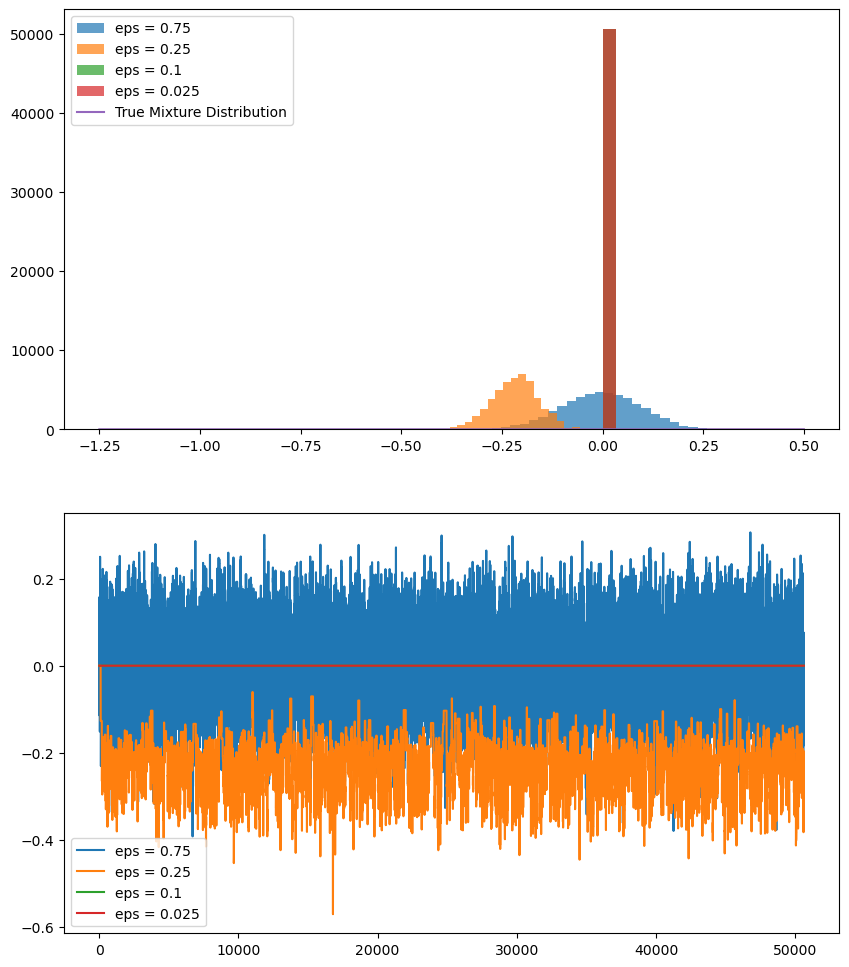

In [66]:
### update (cont.)
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)

fig, axs = plt.subplots(2, figsize=(10,12))
for e in eps:
    theta = abc_mcmc(N_max, M, e, nu_squared, var, var_1, a)
    label = 'eps = %s'%(e)
    axs[0].hist(theta, bins=30, alpha=0.7, label=label)
    axs[1].plot(theta, label=label)
axs[0].plot(x_values, f, label='True Mixture Distribution')
axs[0].legend()
axs[1].legend()
plt.show()

# Point 4 - Calculate summary statistic

In [50]:
# Define parameters of pharmacokinetic model
K_e = 0.08
K_a = 1.5
Cl = 0.04
sigma = 0.2
D = 4

Let us use the Euler-Maruyama method to estimate $X(t)$.

In [51]:
dt = 0.05  # Time step
T = 12  # Total time
n = int(T / dt)+1  # Number of time steps

t = np.arange(0, 12.05, 0.05)  # Vector of times

In [52]:
X_t = np.zeros(n) # Recall that X_0 = 0
for i in range(n - 1):
    X_t[i + 1] = X_t[i] + dt*( (D*K_a*K_e)/Cl * np.exp(-K_a*t[i+1]) - K_e*X_t[i] ) + sigma*np.sqrt(dt)*np.random.randn()

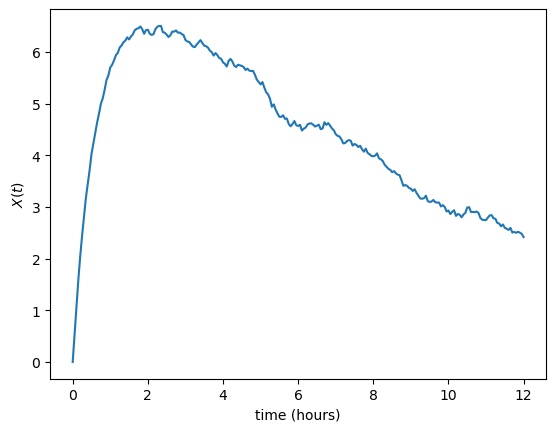

In [53]:
plt.figure()

plt.plot(t, X_t, label=r'$X(t)$')
plt.xlabel('time (hours)')
plt.ylabel(r'$X(t)$')

plt.show()

We fit now a Linear Regression.

In [54]:
times = [0.25, 0.5, 1, 2, 3.5, 5, 7, 9, 12]
indices = np.where(np.isin(t, times))
xs = X_t[indices]
print('data are:', xs)

data are: [2.44395875 4.02265932 5.69949027 6.42977386 6.12211455 5.37171189
 4.40849289 3.35291851 2.41747607]


In [58]:
n_data = 10000
X = np.zeros((n_data, len(times))) 
Y = np.zeros((n_data, 4)) #4 is the number of parameters of interest

for j in range(n_data):
    K_a = np.exp(np.random.normal(0.14, 0.4**2))
    K_e = np.exp(np.random.normal(-2.7, 0.6**2))
    Cl = np.exp(np.random.normal(-3, 0.8**2))
    sigma = np.exp(np.random.normal(-1.1, 0.3**2))
    
    theta = [K_e, K_a, Cl, sigma]
    Y[j,:] = theta
    
    X_t = np.zeros(n) # Recall that X_0 = 0
    for i in range(n - 1):
        X_t[i + 1] = X_t[i] + dt*( (D*K_a*K_e)/Cl * np.exp(-K_a*t[i+1]) - K_e*X_t[i] ) + sigma*np.sqrt(dt)*np.random.randn()
    X[j,:] = X_t[indices]

In [59]:
# Fit linear regression model
model = LinearRegression()
model.fit(X, Y)

# Get the estimated coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

print("Estimated Coefficients:", coefficients)
print("Intercept:", intercept)

Estimated Coefficients: [[-2.84389719e-03 -3.16703106e-04  4.36939277e-03  5.82462954e-03
   1.56612712e-03 -1.60662089e-03 -1.80814766e-03 -3.56026399e-03
  -6.73101394e-03]
 [ 1.77934868e-01  1.28985891e-01  7.71325304e-03 -9.46071863e-02
  -4.69526191e-02 -1.51153846e-02  9.73205046e-03  1.08208932e-02
   1.69541459e-02]
 [-3.71607792e-03  1.21200470e-03  5.96390681e-04  4.25282698e-04
  -1.66064579e-03 -1.28768328e-04 -1.75293074e-03 -1.98108550e-03
  -5.32243839e-03]
 [ 7.10609697e-04  1.83309682e-03 -2.07414835e-03  5.83518226e-04
  -7.68756277e-04  5.35977198e-04  3.28889569e-04  8.22076093e-04
  -1.08531597e-03]]
Intercept: [0.06560934 1.16514742 0.09918915 0.33437548]


Finally, we can calculate the summary statistic $S(\mathcal{D})$ using the first data we generated. 

$S(\mathcal{D}) = \mathbb{E}[\theta| \mathcal{D}]= \begin{bmatrix} \theta_1 \\ \theta_2 \\ \theta_3 \\ \theta_4 \end{bmatrix} = \begin{bmatrix} \beta_0^{(1)} \\ \beta_0^{(2)} \\ \beta_0^{(3)} \\ \beta_0^{(4)} \end{bmatrix} + \begin{bmatrix} \beta_1^{(1)} \ ... \ \beta_9^{(1)} \\ \beta_1^{(2)} \ ... \ \beta_9^{(2)} \\ \beta_1^{(3)} \ ... \ \beta_9^{(3)} \\ \beta_1^{(4)} \ ... \ \beta_9^{(4)} \end{bmatrix} \cdot \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_9 \end{bmatrix}$

In [60]:
S_D = intercept + coefficients@xs
print("Summary statistic is", S_D)

Summary statistic is [0.0845165  1.30606468 0.06302085 0.33517164]


# DEBUG

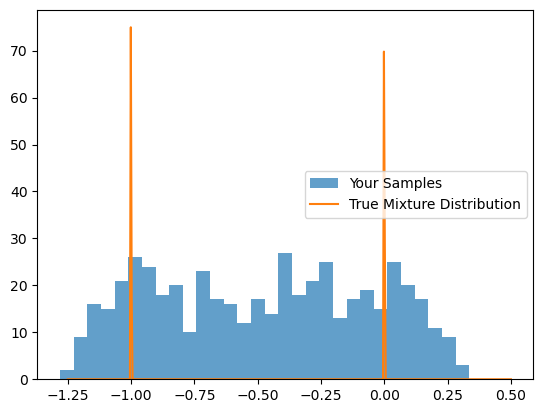

In [209]:
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)

plt.hist(theta, bins=30, alpha=0.7, label='Your Samples')
plt.plot(x_values, f, label='True Mixture Distribution')
plt.legend()
plt.show()

In [208]:
f.sum()

84.68889923237376

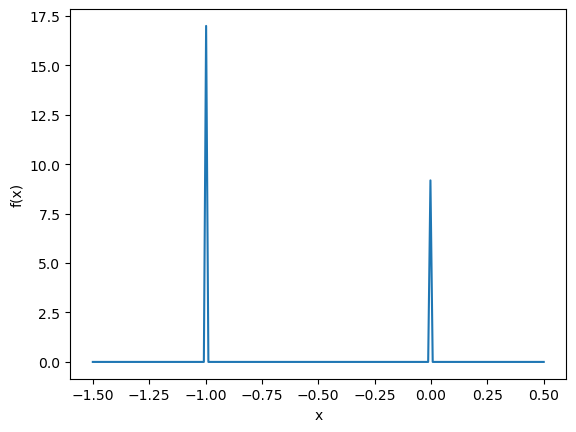

In [169]:
# Set-up.
n = 10000
np.random.seed(0x5eed)
# Parameters of the mixture components
norm_params = np.array([[var/(var+var_1/M)*sample_mean, var_1/(M+var_1/var)],
                        [var/(var+var_1/M)*(sample_mean-a), var_1/(M+var_1/var)]])
n_components = norm_params.shape[0]
# Weight of each component
alfa = 1./( 1 + np.exp( a * (sample_mean - 0.5*a) * M / (M*var + var_1) ) )
weights = [alfa, 1-alfa]

# Theoretical PDF plotting -- generate the x and y plotting positions
xs = np.linspace(-1.5, 0.5, 200)
ys = np.zeros_like(xs)

for (l, s), w in zip(norm_params, weights):
    ys += st.norm.pdf(xs, loc=l, scale=s) * w

plt.plot(xs, ys)
#plt.hist(y, bins="fd")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

In [213]:
label = 'eps = %s'%(eps[1])
label

'eps = 0.25'

In [219]:
len(eps)

4